# Google Play Store Twitter Sentiment Analysis
Data provided by [Kaggle](https://www.kaggle.com/lava18/google-play-store-apps). In addition Twitter will be analyzed for any further data on the app itself.

A coulple questions come to mind:
1. Is there really a corelation between the number of times an app was downloaded and the Twitter sentiment.
2. Try to find from the top 100 apps (based on installs) how each install correlates to the positve and negative sentiments on Twitter.
3. Try to find which genre of apps brings the most positive and negative sentiment out of the top 10 downloads from the play store.


For the purpose of the second task **Syuzhet** will be used. **Syuzhet** get's the sentiment into 10 emotions: anger, anticipation, disgust, fear, joy, sadness, surprise, trust, negative and positive.
The notebook will examine only the positive and negative sentiments for each first 100 tweets for each app.

But first let's start with loading the libraries:

In [1]:
library(ggplot2)
library(Amelia)
library(dplyr)
library(rjson)
library(twitteR)
library(wordcloud)
library(syuzhet)

set.seed(42)

Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.7.4, built: 2015-12-05)
## Copyright (C) 2005-2018 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘twitteR’

The following objects are masked from ‘package:dplyr’:

    id, location

Loading required package: RColorBrewer


## 1. Loading and preprocessing the data and initial observations.

### 1.1 Loading the dataset.

In [2]:
df <- data.frame(read.csv('data/googleplaystore.csv'))

In [3]:
# Displaying the head
head(df)

App,Category,Rating,Reviews,Size,Installs,Type,Price,Content.Rating,Genres,Last.Updated,Current.Ver,Android.Ver
Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
"U Launcher Lite – FREE Live Cool Themes, Hide Apps",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up


### 1.2 Configuring the twitter connection

In [4]:
twitterCreds <- fromJSON(file = "data/twitter_access.json")

In [5]:
setup_twitter_oauth(twitterCreds$consumer_key, 
                    twitterCreds$consumer_secret, 
                    access_token=twitterCreds$access_token, 
                    access_secret=twitterCreds$access_token_secret)

[1] "Using direct authentication"


### 1.3 Getting the bearings of the datasets.
First - let's get the dimensions and structure of the dataset.

In [6]:
dim(df)

[1] 10841    13

In [7]:
str(df)

'data.frame':	10841 obs. of  13 variables:
 $ App           : Factor w/ 9660 levels "- Free Comics - Comic Apps",..: 7206 2551 8970 8089 7272 7103 8149 5568 4926 5806 ...
 $ Category      : Factor w/ 34 levels "1.9","ART_AND_DESIGN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Rating        : num  4.1 3.9 4.7 4.5 4.3 4.4 3.8 4.1 4.4 4.7 ...
 $ Reviews       : Factor w/ 6002 levels "0","1","10","100",..: 1183 5924 5681 1947 5924 1310 1464 3385 816 485 ...
 $ Size          : Factor w/ 462 levels "1,000+","1.0M",..: 55 30 368 102 64 222 55 118 146 120 ...
 $ Installs      : Factor w/ 22 levels "0","0+","1,000,000,000+",..: 8 20 13 16 11 17 17 4 4 8 ...
 $ Type          : Factor w/ 4 levels "0","Free","NaN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Price         : Factor w/ 93 levels "$0.99","$1.00",..: 92 92 92 92 92 92 92 92 92 92 ...
 $ Content.Rating: Factor w/ 7 levels "","Adults only 18+",..: 3 3 3 6 3 3 3 3 3 3 ...
 $ Genres        : Factor w/ 120 levels "Action","Action;Action & Adventure",..: 10 13 10 10 

**Structure summary**:  
From the structure it seems that some columns, that one would expect to be of type *numerical* are actually *categoricals*. The only one that would be true is *Reviews* as the column indicates the number of reviews an app is getting. In addition *Size* also could be translated to a numerical value as there are 462 levels. On the other hand it seems that the column *Installs* is aggregated in 22 levels and is indeed a categorical value. Same goes for the *Price* with 93 levels. The *Last.Updated* column seems like a date-time.  

#### 1.3.1 Cleaning potential errors.

But first let's clean the dataset of any potential errors - what does this mean - we need to check each column if there is a value(s) that is out of context for the column. Let's make a small plan with each of the columns.

1. App - nothing to do here as names can vary quite a lot. However what we can do here is check for duplicates, in case an app has multiple entries.
2. Category - as there aren't many factors we can get the unique values and check if something is out of context.
3. Rating - nothing to do here as well, as the structure of the dataframe indicated it is a numerical - which we expect. Min, max are going to checked.
4. Reviews - check if the column in entirely composed of integers. A non-integer will indicate a problem with the data.
5. Size - looking at the head we can see that if the value begins with a number - it will indicate a valid value. Anything else we have to do per item basis.
6. Installs - again like the reviews - if the first digit is an integer its okay - else process it manually.
7. Type - only 4 factors, thus we can examine them one by one.
8. Price - again a simple check - the first char should be either a 0, an F (for Free) or a dollar sign.
9. Content.Rating - only 7 factors - again we can treat them case by case.
10. Genres - this is a tricky one as the case can be as the App column. We can leave it for now and see if outliers happen go back and fix them.
11. Last.Updated - try to convert to  a date - if it fails - examine it.
12. Curent.Ver & Android.Ver - leave as is, as they are not intended to be used.

##### *1. App*

In [8]:
# If there are only unique values it should return a 0
dim(df)[1] - dim(unique(df))[1]

[1] 483

It seems some of the rows are duplicates of others - thus we can take just the unique values of the dataframe and assign it to the examined df.

In [9]:
df <- df[!duplicated(df$App), ]

However some apps can be present on the list with multiple values but have different columns. Thus we need to check whether there is a difference between the length of the datafraeme and the unique values for names. Then we can take an example or 2 and check for the difference.

In [10]:
dim(df)

[1] 9660   13

##### *2. Category*

In [11]:
unique(df$Category)

[1] ART_AND_DESIGN      AUTO_AND_VEHICLES   BEAUTY             
 [4] BOOKS_AND_REFERENCE BUSINESS            COMICS             
 [7] COMMUNICATION       DATING              EDUCATION          
[10] ENTERTAINMENT       EVENTS              FINANCE            
[13] FOOD_AND_DRINK      HEALTH_AND_FITNESS  HOUSE_AND_HOME     
[16] LIBRARIES_AND_DEMO  LIFESTYLE           GAME               
[19] FAMILY              MEDICAL             SOCIAL             
[22] SHOPPING            PHOTOGRAPHY         SPORTS             
[25] TRAVEL_AND_LOCAL    TOOLS               PERSONALIZATION    
[28] PRODUCTIVITY        PARENTING           WEATHER            
[31] VIDEO_PLAYERS       NEWS_AND_MAGAZINES  MAPS_AND_NAVIGATION
[34] 1.9                
34 Levels: 1.9 ART_AND_DESIGN AUTO_AND_VEHICLES BEAUTY ... WEATHER

Right of the bat we encounter an error. - 1.9 should not be there. Since the data is a csv, this is likely caused by missing a comma. Let's try to find the number of these columns.

In [12]:
length(df[df$Category == 1.9,]$Category)

[1] 1

Just one row - we can drop it.

In [13]:
df = df[!(df$Category == 1.9),]

##### *3. Rating*

In [14]:
min(df$Rating)

[1] NaN

It seems that there are missing values in the Rating column. If we check the unique values we can see if some the ratings are missing. The Google Play Reviews are in the range 0 to 5.

In [15]:
unique(df$Rating)

[1] 4.1 3.9 4.7 4.5 4.3 4.4 3.8 4.2 4.6 3.2 4.0 NaN 4.8 4.9 3.6 3.7 3.3 3.4 3.5
[20] 3.1 5.0 2.6 3.0 1.9 2.5 2.8 2.7 1.0 2.9 2.3 2.2 1.7 2.0 1.8 2.4 1.6 2.1 1.4
[39] 1.5 1.2

It seems that the 0 is missing - that means the App hasn't yet been rated. We will assign 0 to them.

In [16]:
df[is.na(df$Rating), 'Rating'] = 0

##### *4. Reviews*

In [17]:
# should give us an error if there is a value we need to take into an account
df$Reviews = as.numeric(as.character(df$Reviews))

What we need to check is whether some values 

##### *5. Size*

In [18]:
# bad code a head
non_numeric_size <- c()
for (item in unique(df$Size)) {
    x = is.na(as.numeric(substr(as.character(item), 1, 1)))
    if(x) {
        non_numeric_size <- c(non_numeric_size, item)
    }
}

print(non_numeric_size)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

[1] "Varies with device"


So it seems that the only issue is with "Varies with device", which is a valid category.
##### *6.Installs*

In [19]:
z = as.numeric(as.character(df$Installs))

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

It returned a warning, that some of the values cannot be effectively transformed to numeric ones. Since there are only 22 levels we can inspect them one by one.

In [20]:
unique(df$Installs)

[1] 10,000+        500,000+       5,000,000+     50,000,000+    100,000+      
 [6] 50,000+        1,000,000+     10,000,000+    5,000+         100,000,000+  
[11] 1,000,000,000+ 1,000+         500,000,000+   50+            100+          
[16] 500+           10+            1+             5+             0+            
[21] 0             
22 Levels: 0 0+ 1,000,000,000+ 1,000,000+ 1,000+ 1+ 10,000,000+ 10,000+ ... Free

It seems that the `+` sign after each level created the problem. But we see that the values are numeric. It is a categorical variable, grouped by multiples of 5/10, but it will serve more purpose as a numerical variable.

In [21]:
clean_plus <- function(val) {
    val_str <- as.character(val)
    if (nchar(val_str) == 1) {
        return(val)
    } else {
        return(as.numeric(gsub('\\,','', substr(val_str, 1, nchar(val_str) - 1))))
    }
}

In [22]:
df$Installs <- sapply(df$Install, clean_plus)

##### *7. Type*

In [23]:
unique(df$Type)

[1] Free Paid NaN 
Levels: 0 Free NaN Paid

The structure reported that we have 4 factors, but here there are only 3. Same with the *Installs* column - it seems that the row that was dropped in *Category* removed an unnesecary category.

##### 8. *Price*

In [24]:
irregular_items <- c()
for (item in unique(df$Price)) {
    if (!(substr(item,1,1) == '$' | substr(item,1,1) == '0')) {
        irregular_items <- c(irregular_items, item)
    }
}

print(irregular_items)

NULL


The check returned an empty list.

##### *9. Content.Rating*

In [25]:
unique(df$Content.Rating)

[1] Everyone        Teen            Everyone 10+    Mature 17+     
[5] Adults only 18+ Unrated        
Levels:  Adults only 18+ Everyone Everyone 10+ Mature 17+ Teen Unrated

This column seems right and no unexpected values came up.

##### *11 Last.Updated*

In [26]:
Sys.setlocale('LC_TIME', 'C') # To work with the format
df$Last.Updated <- as.Date(df$Last.Updated, format="%B %d, %Y")

[1] "C"

Let's verify the structure once more.

In [27]:
str(df)

'data.frame':	9659 obs. of  13 variables:
 $ App           : Factor w/ 9660 levels "- Free Comics - Comic Apps",..: 7206 2551 8970 8089 7272 7103 8149 5568 4926 5806 ...
 $ Category      : Factor w/ 34 levels "1.9","ART_AND_DESIGN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Rating        : num  4.1 3.9 4.7 4.5 4.3 4.4 3.8 4.1 4.4 4.7 ...
 $ Reviews       : num  159 967 87510 215644 967 ...
 $ Size          : Factor w/ 462 levels "1,000+","1.0M",..: 55 30 368 102 64 222 55 118 146 120 ...
 $ Installs      : num  1e+04 5e+05 5e+06 5e+07 1e+05 5e+04 5e+04 1e+06 1e+06 1e+04 ...
 $ Type          : Factor w/ 4 levels "0","Free","NaN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Price         : Factor w/ 93 levels "$0.99","$1.00",..: 92 92 92 92 92 92 92 92 92 92 ...
 $ Content.Rating: Factor w/ 7 levels "","Adults only 18+",..: 3 3 3 6 3 3 3 3 3 3 ...
 $ Genres        : Factor w/ 120 levels "Action","Action;Action & Adventure",..: 10 13 10 10 12 10 10 10 10 12 ...
 $ Last.Updated  : Date, format: "2018-01-07" "2018-0

All seems according to plan.

#### 1.3.2 Initial Data Visiualization.
Let's treat the `Installs` as a target variable to explore the relationship between it and the other columns.

*-Category and Installs*

In [28]:
df.grp.cat <- aggregate(x = df$Installs, by=list(Category=df$Category), FUN=mean)
colnames(df.grp.cat) <- c('Category', 'Installs')

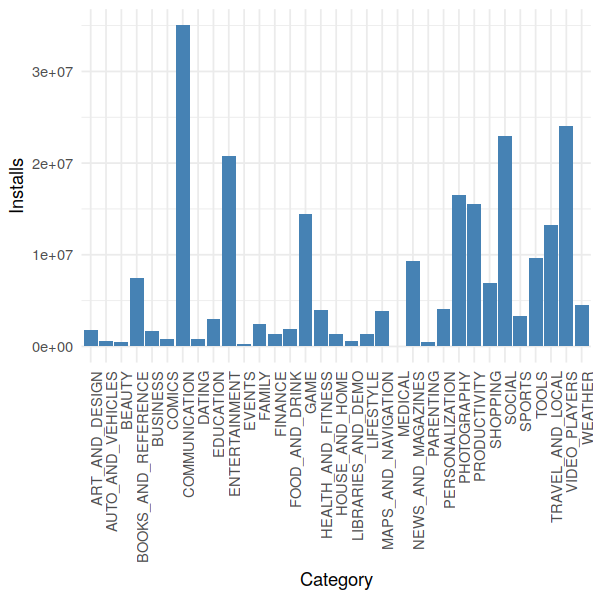

In [29]:
options(repr.plot.width=5, repr.plot.height=5)
pl <- ggplot(df.grp.cat, aes(Category, Installs)) + geom_bar(stat='identity', fill="steelblue") 
pl + theme_minimal() + theme(axis.text.x = element_text(angle = 90, hjust = 1))

It seems obvious that 'Communication' and 'Social' are the most popular categories, by far, on Google play.

*- Rating and Installs*

In [30]:
# Creating a function that will group the ratings to the highest, according to a sequence.
ratingGroup <- function(rating, rsequence) {
    rating.group <- 0
    if (rating == 0) {
        rating.group <- rsequence[1]
    } else {
        c <- 1
        for (i in rsequence) {
            if(rating > i & rating <= rsequence[c+1]) {
                rating.group <- rsequence[c+1]
            }
            c <- c + 1
        }
    }
    
    return(rating.group)
}

In [31]:
# rsequence=seq(min(df$Rating), max(df$Rating), length=11)
df$RatingGroup <- sapply(df$Rating, ratingGroup, rsequence=seq(min(df$Rating), max(df$Rating), length=26))
df.grp.rat <- aggregate(x = df$Installs, by=list(RatingGroup=df$RatingGroup), FUN=mean)
colnames(df.grp.rat) <- c('RatingGroup', 'Installs')

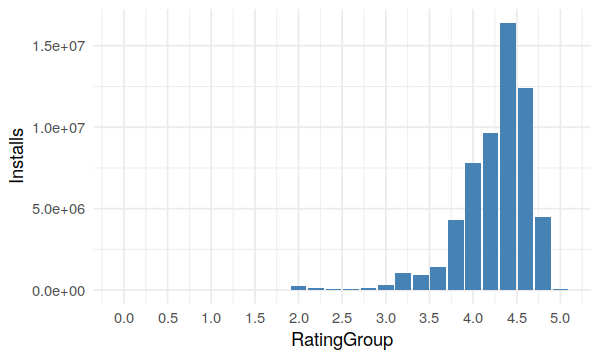

In [32]:
options(repr.plot.width=5, repr.plot.height=3)
pl <- ggplot(df.grp.rat, aes(RatingGroup, Installs)) + geom_bar(stat='identity', fill="steelblue") 
pl + scale_x_continuous(breaks = seq(min(df$Rating), max(df$Rating), length=11)) + theme_minimal()

It seems that most of the apps, that have any installs at all, are clustered together between ratings 4 and 5.

*-Reviews and Installs*
I will going to reuse the function from the last section.

In [33]:
df$ReviewCountGrp <- sapply(df$Reviews, ratingGroup, rsequence=seq(min(df$Reviews), max(df$Reviews), length=26))
df.grp.rev <- aggregate(x = df$Installs, by=list(ReviewCountGrp=df$ReviewCountGrp), FUN=mean)
colnames(df.grp.rev) <- c('ReviewCountGrp', 'Installs')

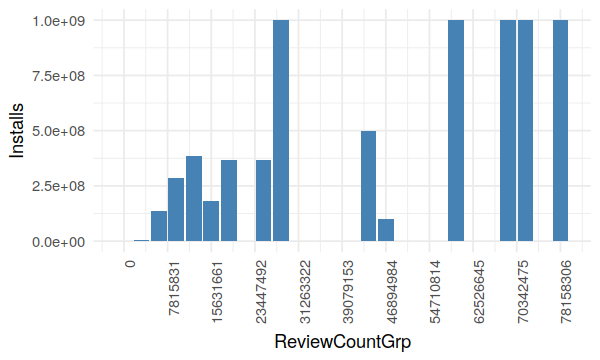

In [34]:
options(repr.plot.width=5, repr.plot.height=3)
pl <- ggplot(df.grp.rev, aes(ReviewCountGrp, Installs)) + geom_bar(stat='identity', fill="steelblue") 
pl + scale_x_continuous(breaks = seq(min(df$Reviews), max(df$Reviews), length=11)) + theme_minimal() + theme(axis.text.x = element_text(angle = 90, hjust = 1))

It seems that the number of reviews have no impact on the installs. Actually one would expect that the ReviewCount to be lower than the installs as not all who install leave a review.  

*-Type and Installs*

In [35]:
df.grp.type <- aggregate(x = df$Installs, by=list(Type=df$Type), FUN=mean)
colnames(df.grp.type) <- c('Type', 'Installs')

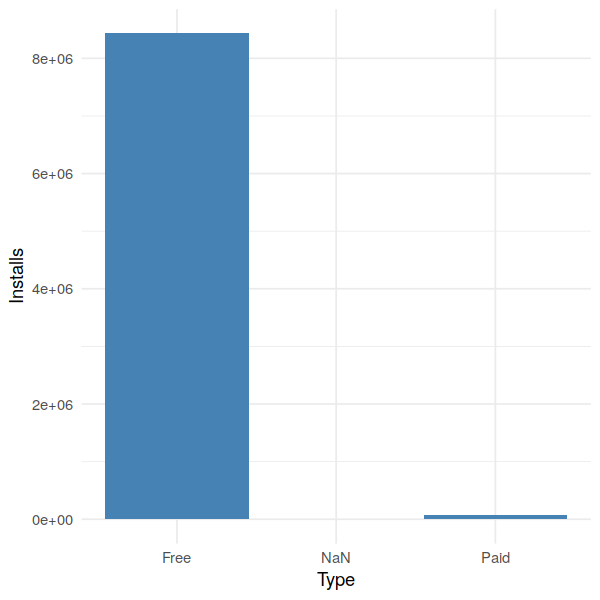

In [36]:
options(repr.plot.width=5, repr.plot.height=5)
pl <- ggplot(df.grp.type, aes(Type, Installs)) + geom_bar(stat='identity', fill="steelblue") 
pl + theme_minimal()

Well, that was expected - the mean number of installs of a free app is way higher than the paid ones.  

*-Genres and Installs*

In [37]:
df.grp.gen <- aggregate(x = df$Installs, by=list(Genre=df$Genres), FUN=mean)
colnames(df.grp.gen) <- c('Genre', 'Installs')

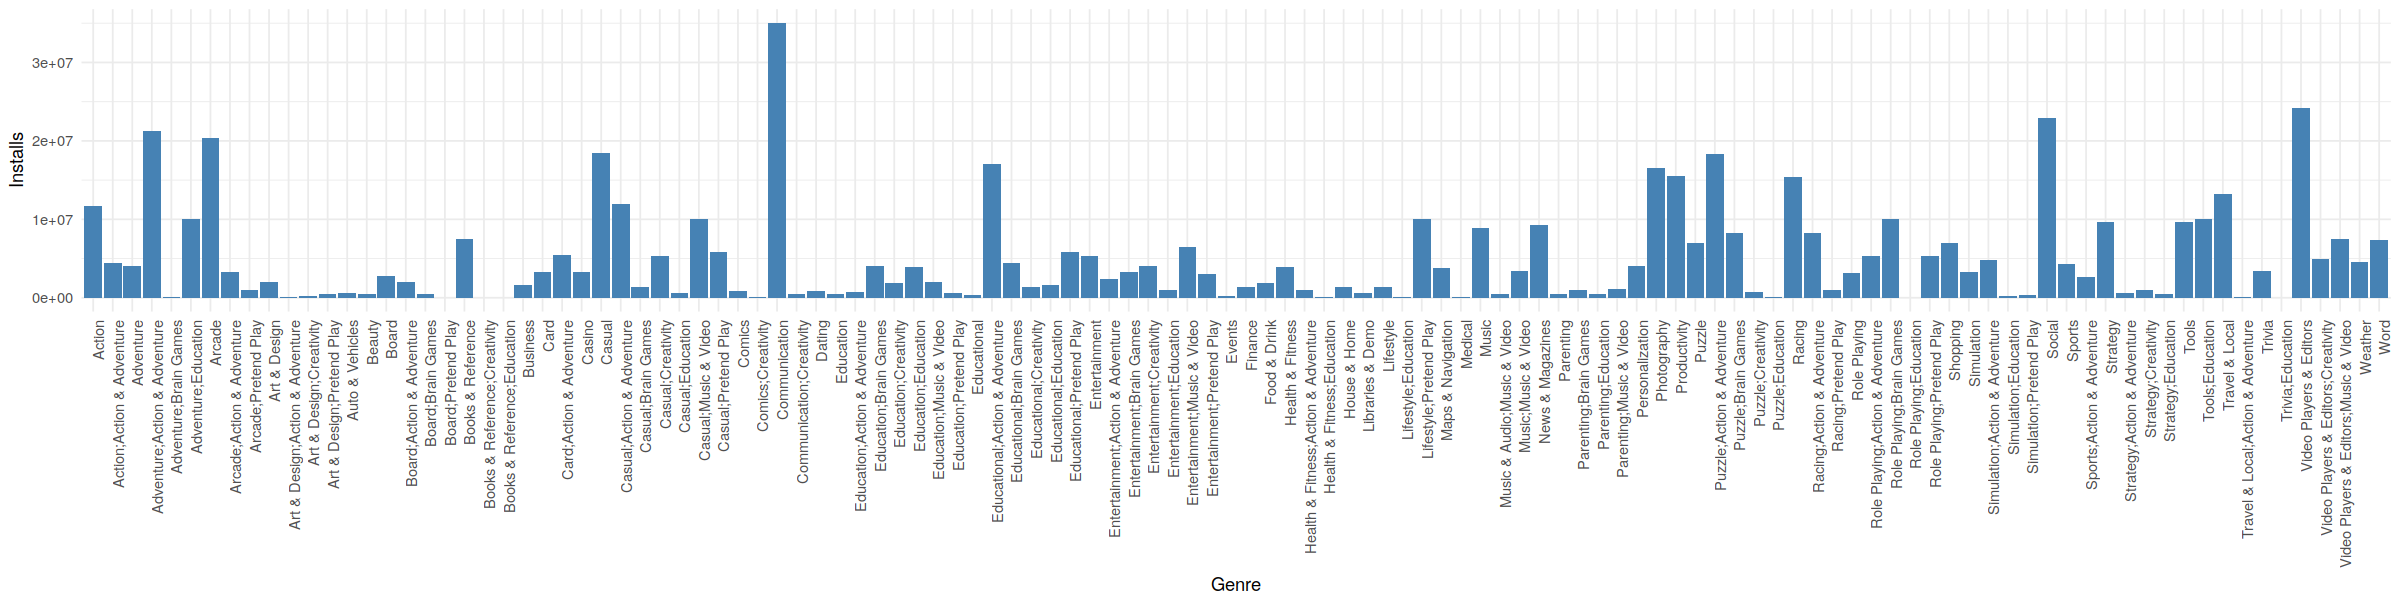

In [38]:
options(repr.plot.width=20, repr.plot.height=5)
pl <- ggplot(df.grp.gen, aes(Genre, Installs)) + geom_bar(stat='identity', fill="steelblue") 
pl + theme_minimal() + theme(axis.text.x = element_text(angle = 90, hjust = 1))

A better way for getting the real genres is to create a genre vector to each of the apps, so that we can see the app with what genre vector is the most popular. Or break it down to a singular genre. But doing a massive plot like this shows us that while 'Communication' is predominant and there are no surprises for 'Social' and 'Video Playback', there are aditional genres that receive a higher number of installs - like 'Action & Adventure' and 'Arcade'.  

*-Price*

In [39]:
df.grp.price <- aggregate(x = df$Installs, by=list(Price=df$Price), FUN=mean)
colnames(df.grp.price) <- c('Price', 'Installs')

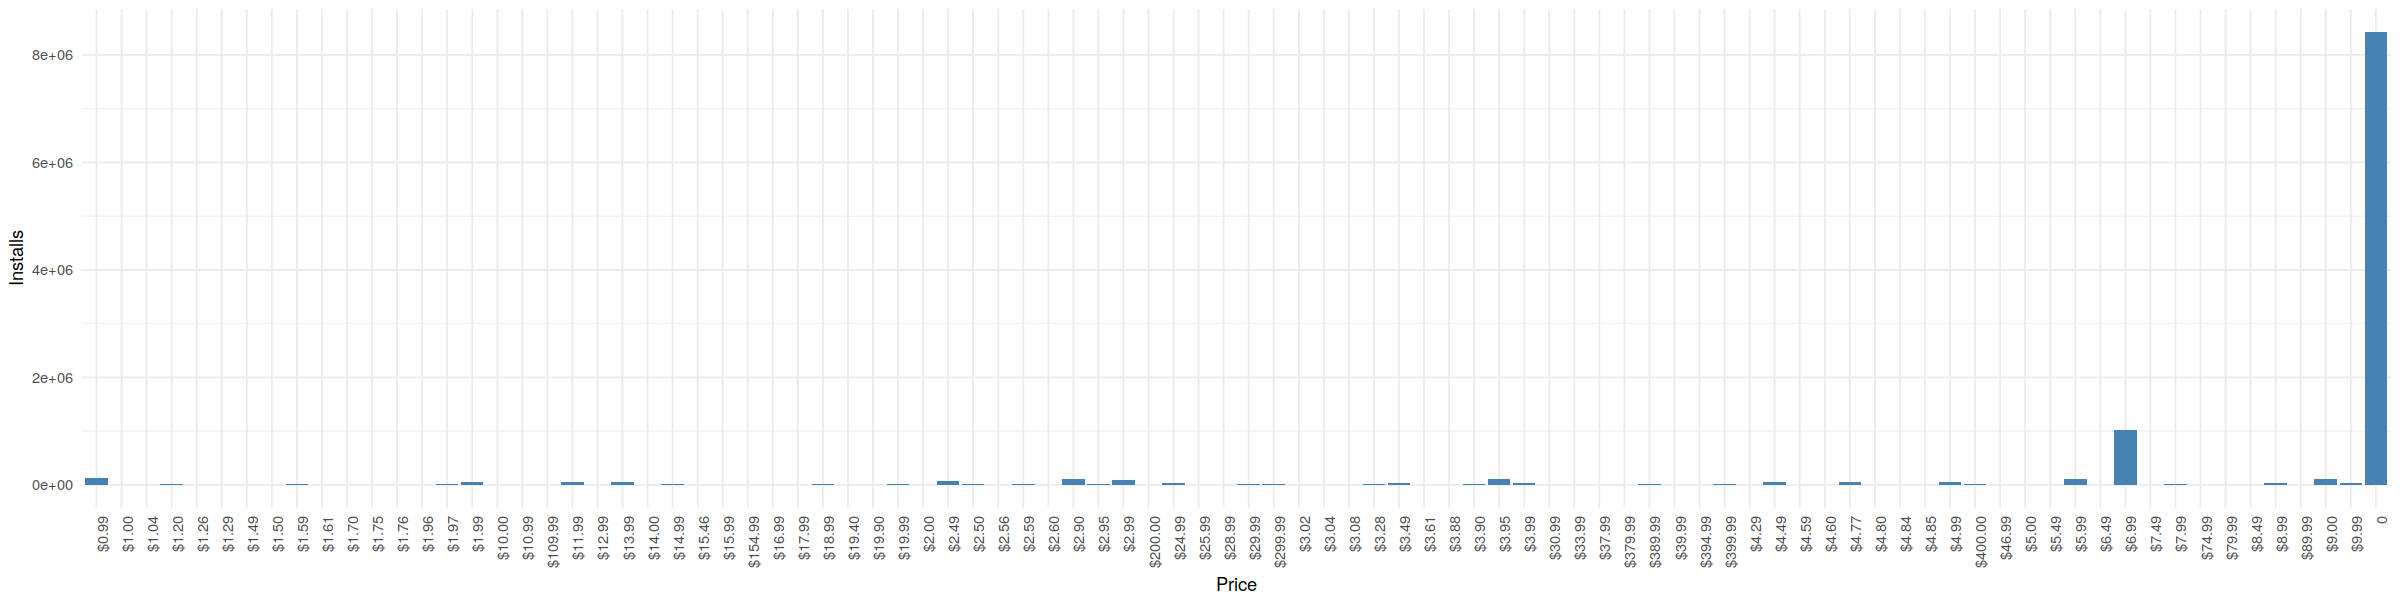

In [40]:
options(repr.plot.width=20, repr.plot.height=5)
pl <- ggplot(df.grp.price, aes(Price, Installs)) + geom_bar(stat='identity', fill="steelblue") 
pl + theme_minimal() + theme(axis.text.x = element_text(angle = 90, hjust = 1))

Again a kind-of-a-lazy solution - treat the price as a factor and get a big visualization, which gives the information that we could have already guessed - Free Apps have a huge install base. The interesting part is when we ignore this value. It seems that apps that cost $6.99 have also a huge install base.

#### 1.4. Findings from the initial exploration
`Placeholder summary`

#### 1.5 Sorting the dataframe based on the number of installs

In [41]:
# sdf = sorted dataframe
sdf <- df[order(-df$Installs), ]

In [42]:
sdf_top100 <- head(sdf, 100)

In [43]:
# Quick check, another head
head(sdf_top100)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content.Rating,Genres,Last.Updated,Current.Ver,Android.Ver,RatingGroup,ReviewCountGrp
153,Google Play Books,BOOKS_AND_REFERENCE,3.9,1433233,Varies with device,1e+09,Free,0,Teen,Books & Reference,2018-08-03,Varies with device,Varies with device,4.0,3126332
336,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56642847,Varies with device,1e+09,Free,0,Everyone,Communication,2018-08-01,Varies with device,Varies with device,4.0,59400313
337,WhatsApp Messenger,COMMUNICATION,4.4,69119316,Varies with device,1e+09,Free,0,Everyone,Communication,2018-08-03,Varies with device,Varies with device,4.4,71905642
339,Google Chrome: Fast & Secure,COMMUNICATION,4.3,9642995,Varies with device,1e+09,Free,0,Everyone,Communication,2018-08-01,Varies with device,Varies with device,4.4,12505329
341,Gmail,COMMUNICATION,4.3,4604324,Varies with device,1e+09,Free,0,Everyone,Communication,2018-08-02,Varies with device,Varies with device,4.4,6252664
342,Hangouts,COMMUNICATION,4.0,3419249,Varies with device,1e+09,Free,0,Everyone,Communication,2018-07-21,Varies with device,Varies with device,4.0,6252664


**Plan**:  
1. ~~*Preprocessing Data:*~~
    * ~~Check for outliers, as I saw some of the factors are unexpected, when taking into account the column's context.~~
    * ~~Finish transforming the other columns.~~
2. *Initial Dataviz:*  
    * ~~Treat `Installs` as a target variable and get the relation between the Category, Rating, #Reviews, Type, Genres and Price.~~
3. *Sort the dataset, based on Installs and start scraping Twitter.*

## 2. Scraping Twitter.

In [44]:
cleanAppName <- function(original) {
    # correct the long-hyphen if it has one
    original <- gsub('[[:punct:]]', '-', original)
    # remove any TMs
    original <- gsub('™', '', original)
    # separate the title from the sub-title of the app and take only the main title
    resvec <- c()
    i <- 1
    checkvec <- c(':','-') # vector with all the know separators
    while(length(resvec) < 2) {
        resvec <- unlist(strsplit(original, checkvec[i]))
        i <- i + 1
        if (i > 2) {
            break
        }
    }
    
    resvec[1] <- trimws(resvec[1]) # trim any trailing white space
    return(resvec[1])
}

getTweets <- function(name, ntweets) {
    tweets <- searchTwitter(name, n=ntweets, lang='en', retryOnRateLimit=50) # search for the app
    df.tweets <- twListToDF(tweets) # transform to df
    
    sentiment <- as.data.frame(get_nrc_sentiment(df.tweets$text)) # get the sentiment
    agg.sentiment <- colSums(sentiment[,c('positive','negative')]) # get only the positve and negative
    agg.sent <- c(name, agg.sentiment[['positive']], agg.sentiment[['negative']])
    return(agg.sent)
}

createSentimentDF <- function(apps) {
    sntmDF <- data.frame()
    for (app in apps) {
        print(app)
        agg.sentiment <- getTweets(app, 10)
        sntmDF <- rbind(sntmDF, data.frame(agg.sentiment))
    }
    colnames(sntmDF) <- c('App', 'Positive', 'Negative')
    return(sntmDF)
}

In [45]:
sdf_top100$CleanApp <- sapply(sdf_top100$App, cleanAppName)

In [46]:
#sentiment.df <- createSentimentDF(sdf_top100$CleanApp)

In [47]:
# test with rtweet
library(rtweet)


Attaching package: ‘rtweet’

The following object is masked from ‘package:syuzhet’:

    get_tokens

The following object is masked from ‘package:twitteR’:

    lookup_statuses



In [48]:
create_token(app = 'dslm-twitter-mine',
             consumer_key = twitterCreds$consumer_key, 
             consumer_secret = twitterCreds$consumer_secret, 
             access_token=twitterCreds$access_token, 
             access_secret=twitterCreds$access_token_secret)

<Token>
<oauth_endpoint>
 request:   https://api.twitter.com/oauth/request_token
 authorize: https://api.twitter.com/oauth/authenticate
 access:    https://api.twitter.com/oauth/access_token
<oauth_app> dslm-twitter-mine
  key:    Z11Ps0AZQvdslxnIavxErGCTQ
  secret: <hidden>
<credentials> oauth_token, oauth_token_secret
---

In [74]:
getTweetsRtw <- function(name, ntweets) {
    df.tweets <- search_tweets(paste(name, 'lang:en', ' '), n = ntweets, retryonratelimit = T, verbose = F) # search for the app
    
    if (dim(df.tweets)[1] != 0) { # check if the returned dataframe is not empty
        sentiment <- as.data.frame(get_nrc_sentiment(df.tweets$text)) # get the sentiment
        agg.sentiment <- colSums(sentiment[,c('positive','negative')]) # get only the positve and negative
        agg.sent <- c(name, agg.sentiment[['positive']], agg.sentiment[['negative']])
    } else {
        agg.sent <- c(name, 0, 0) # there is a slight possibility that twitter doesn't find anything... return 0s
    }
    
    return(agg.sent)
}

createSentimentDFRTW <- function(apps) {
    sntmDF <- data.frame()
    counter <- 0
    total <- length(apps)

    for (app in apps) {
        counter <- counter + 1
        print(paste(app,'', counter, '/', total))
        agg.sentiment <- getTweetsRtw(app, 50)
        sntmDF <- rbind(sntmDF, data.frame(agg.sentiment))
    }

    return(sntmDF)
}

In [ ]:
sntdf <- createSentimentDFRTW(sdf_top100$CleanApp)